## Fazendo a integração com o conjunto de dados do Kaggle

In [1]:
# Faz upload do arquivo "kaggle.json" com API Token do perfil do usuário
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# Testa se upload foi feito com sucesso
!ls

kaggle.json  sample_data


In [3]:
# Move arquivo para a uma pasta e dá permissões ao sistema
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Fazendo download do dataset
! kaggle datasets download -d ealaxi/paysim1

100% 178M/178M [00:01<00:00, 107MB/s]
100% 178M/178M [00:01<00:00, 112MB/s]


In [5]:
# Conferindo o download
!ls

kaggle.json  paysim1.zip  sample_data


## Construindo o modelo dos dados na memória

In [6]:
import zipfile
import pandas as pd
 
# Cria dataframe do pandas a partir do zip
df = pd.read_csv('paysim1.zip',compression='zip')
 
# Trocando nome de oldbalanceOrg para oldbalanceOrig
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})

# Exibindo o começo do dataframe
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Removendo as colunas inúteis
df = df.drop(labels=["isFlaggedFraud", "newbalanceDest", "newbalanceOrig", "nameDest", "nameOrig"], axis=1)

# Informando que isFraud é booleano
df["isFraud"] = df["isFraud"].astype("bool")
df.head()

,step,type,amount,oldbalanceOrig,oldbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,0.0,False
1,1,PAYMENT,1864.28,21249.0,0.0,False
2,1,TRANSFER,181.00,181.0,0.0,True
3,1,CASH_OUT,181.00,181.0,21182.0,True
4,1,PAYMENT,11668.14,41554.0,0.0,False


## Análises de distribuição dos dados


In [ ]:
# Analisando a quantidade de fraudes
df["isFraud"].value_counts(normalize=True)

False    0.998709
True     0.001291
Name: isFraud, dtype: float64

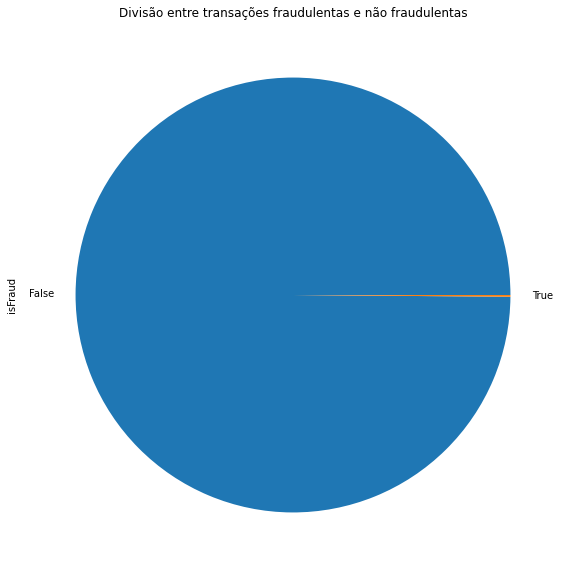

In [ ]:
# Plotando as proporções entre fraudes e não fraudes
df["isFraud"].value_counts(normalize = True).plot.pie(figsize = (10,10),
                                                      title = "Divisão entre transações fraudulentas e não fraudulentas")

Temos uma proporção de 0,13% de transações fraudulentas, um número realista em comparação com transações reais.

In [ ]:
# Separando fraudes de não fraudes
frauds = df[df["isFraud"] == True]
not_frauds = df[df["isFraud"] == False]

In [ ]:
# Visualizando algumas transações fraudulentas
frauds.head(100)

,step,type,amount,oldbalanceOrig,oldbalanceDest,isFraud
2,1,TRANSFER,181.00,181.00,0.00,True
3,1,CASH_OUT,181.00,181.00,21182.00,True
251,1,TRANSFER,2806.00,2806.00,0.00,True
252,1,CASH_OUT,2806.00,2806.00,26202.00,True
680,1,TRANSFER,20128.00,20128.00,0.00,True
...,...,...,...,...,...,...
47145,9,CASH_OUT,350705.74,350705.74,894760.68,True
49825,9,TRANSFER,2539898.07,2539898.07,0.00,True
49826,9,CASH_OUT,2539898.07,2539898.07,968.00,True
49885,9,TRANSFER,361559.69,361559.69,0.00,True


Perceba que muitas transações fraudulentas aparecem "em dupla", uma de tipo transferência seguida de outra do tipo saque de mesmo valor e após 1 hora. Concluímos então que essas transações ocorrem de modo planejado: logo após a realização da transferência, o dinheiro é retirado.

In [ ]:
# Descrevendo as transações fraudulentas
frauds.describe(include=["object", "int", "float"])

,step,type,amount,oldbalanceOrig,oldbalanceDest
count,8213.000000,8213,8.213000e+03,8.213000e+03,8.213000e+03
unique,NaN,2,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,NaN,NaN
freq,NaN,4116,NaN,NaN,NaN
mean,368.413856,NaN,1.467967e+06,1.649668e+06,5.442496e+05
std,216.388690,NaN,2.404253e+06,3.547719e+06,3.336421e+06
min,1.000000,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,181.000000,NaN,1.270913e+05,1.258224e+05,0.000000e+00
50%,367.000000,NaN,4.414234e+05,4.389835e+05,0.000000e+00
75%,558.000000,NaN,1.517771e+06,1.517771e+06,1.478287e+05


In [ ]:
# Verificando a proporção entre os tipos de transações consideradas fraudulentas
frauds["type"].value_counts(normalize = True)

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

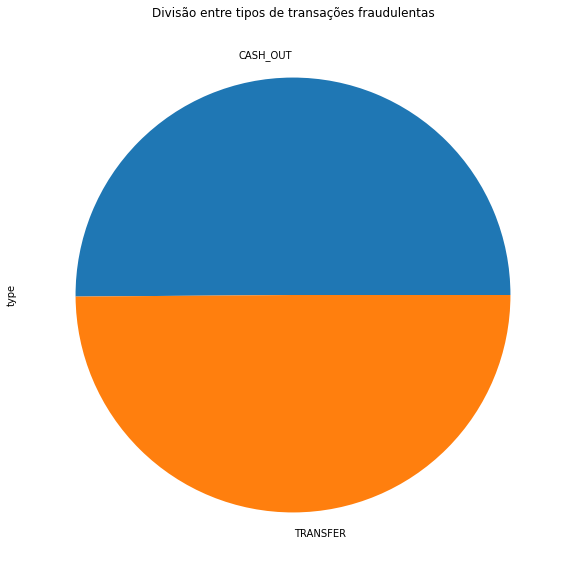

In [ ]:
# Plotando as proporções entre os tipos de transações
frauds["type"].value_counts(normalize = True).plot.pie(figsize = (10,10),
                                                       title = "Divisão entre tipos de transações fraudulentas")

Note que há apenas dois tipos de transações consideradas fraudulentas: saque e transferência, divididas em proporções quase equivalentes. Isso torna a análise do tipo da transação crucial para decidir entre fraudes e não fraudes (provavelmente será o primeiro atributo a ser analisado pela árvore).

In [ ]:
# Dividindo as fraudes pelo tipo da fraude
cash_out_fraud = frauds[frauds["type"] == "CASH_OUT"]
transfer_fraud = frauds[frauds["type"] == "TRANSFER"]

In [ ]:
# Verificando a proporção entre os tipos de transações
df["type"].value_counts(normalize = True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

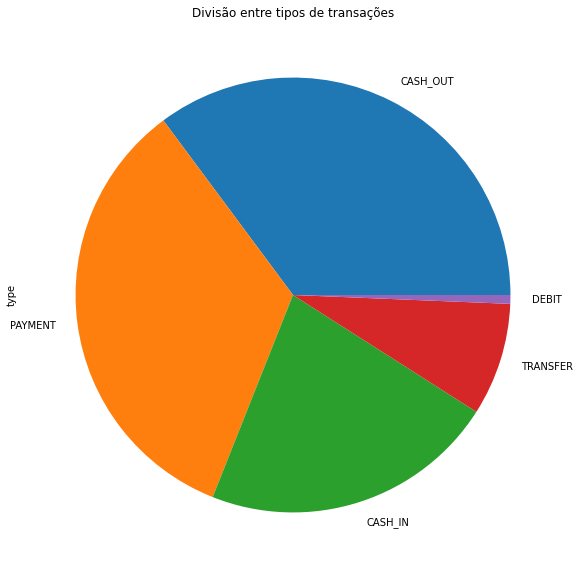

In [ ]:
# Plotando as proporções entre os tipos de transações
df["type"].value_counts(normalize = True).plot.pie(figsize = (10,10),
                                                   title = "Divisão entre tipos de transações")

Perceba que a maior parte das transações pertence a tipos não fraudáveis (depósito, pagamento e débito), o que ajuda a explicar a baixa proporção de fraudes nos dados.

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

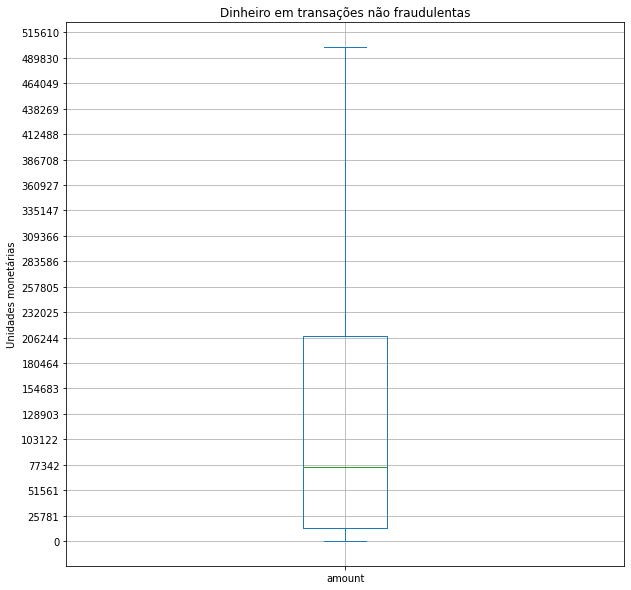

In [ ]:
# Analisando a quantidade de dinheiro em transações não fraudulentas
import numpy as np
first = not_frauds["amount"].quantile(0)
last = not_frauds["amount"].quantile(0.95)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
not_frauds.plot.box(y="amount", figsize = (10,10), grid = True, yticks = ticks, ylabel="Unidades monetárias", showfliers = False,
                    title = "Dinheiro em transações não fraudulentas")
not_frauds["amount"].describe()

Transações não fraudulentas se concentram em torno de 77000, variando de 25000 a 210000 em sua maioria.

count    6.354407e+06
mean     8.328287e+05
std      2.887144e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.406900e+04
75%      1.069695e+05
max      4.381886e+07
Name: oldbalanceOrig, dtype: float64

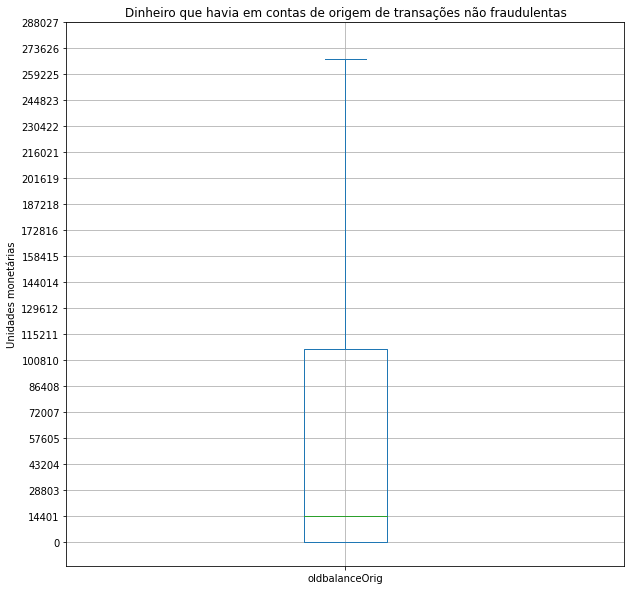

In [ ]:
# Analisando a quantidade de dinheiro que havia em contas de origem de transações não fraudulentas
import numpy as np
first = not_frauds["oldbalanceOrig"].quantile(0)
last = not_frauds["oldbalanceOrig"].quantile(0.83)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
not_frauds.plot.box(y="oldbalanceOrig", figsize = (10,10), grid = True, yticks = ticks, ylabel="Unidades monetárias", showfliers = False,
                    title = "Dinheiro que havia em contas de origem de transações não fraudulentas")
not_frauds["oldbalanceOrig"].describe()

Contas que realizam transações não fraudulentas costumam ter menos que 100000 em dinheiro. Além disso, a maior parte possui menos de 15000 em conta.

count    6.354407e+06
mean     1.101421e+06
std      3.399202e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.333118e+05
75%      9.441446e+05
max      3.560159e+08
Name: oldbalanceDest, dtype: float64

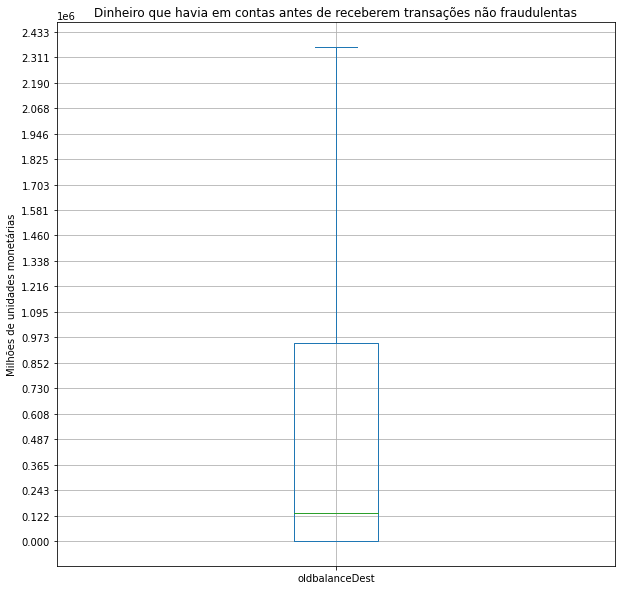

In [ ]:
# Analisando a quantidade de dinheiro que havia em  contas antes de receberem transações não fraudulentas
import numpy as np
first = not_frauds["oldbalanceDest"].quantile(0)
last = not_frauds["oldbalanceDest"].quantile(0.88)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
not_frauds.plot.box(y="oldbalanceDest", figsize = (10,10), grid = True, yticks = ticks, ylabel="Milhões de unidades monetárias", showfliers = False,
                    title = "Dinheiro que havia em contas antes de receberem transações não fraudulentas")
not_frauds["oldbalanceDest"].describe()

Contas que recebem transações não fraudulentas possuem muito mais dinheiro que contas que realizam a transação. Isso se dá ao fato de muitas dessas transações serem pagamentos de pessoas físicas a empresas.

count    4.116000e+03
mean     1.455103e+06
std      2.393842e+06
min      0.000000e+00
25%      1.254645e+05
50%      4.355169e+05
75%      1.500761e+06
max      1.000000e+07
Name: amount, dtype: float64

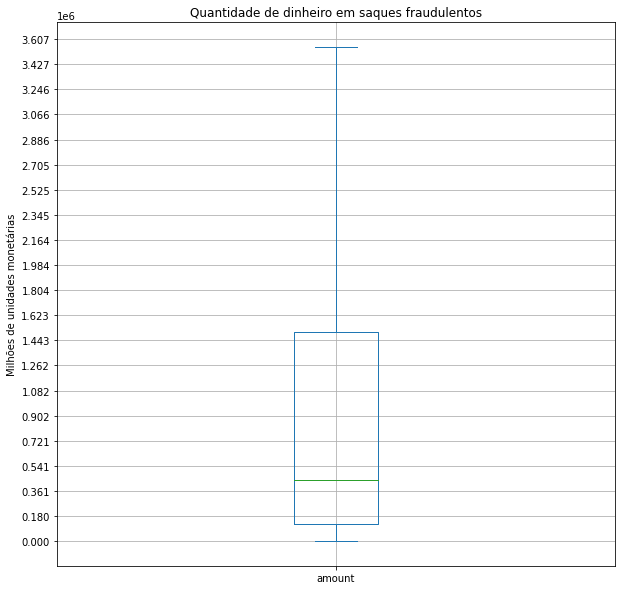

In [ ]:
# Analisando a quantidade de dinheiro em saques fraudulentos
import numpy as np
first = cash_out_fraud["amount"].quantile(0)
last = cash_out_fraud["amount"].quantile(0.88)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
cash_out_fraud.plot.box(y="amount", figsize = (10,10), grid = True, yticks = ticks, ylabel="Milhões de unidades monetárias", showfliers = False,
                        title = "Quantidade de dinheiro em saques fraudulentos")
cash_out_fraud["amount"].describe()

Percebemos que as fraudes envolvem bastante dinheiro, com a maior parte dos saques passando dos 430000. Saques abaixo de 100000 são raros.


count    4.116000e+03
mean     1.453869e+06
std      2.394506e+06
min      0.000000e+00
25%      1.232310e+05
50%      4.336777e+05
75%      1.500761e+06
max      1.000000e+07
Name: oldbalanceOrig, dtype: float64

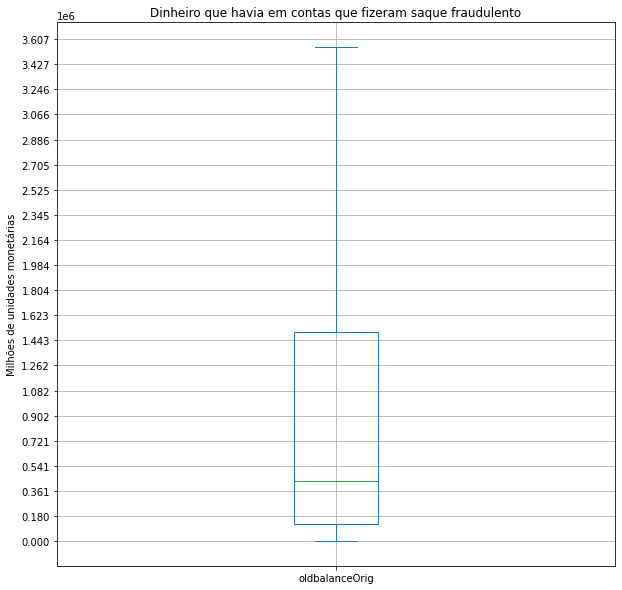

In [ ]:
# Analisando a quantidade de dinheiro que havia em contas que fizeram saque fraudulento
import numpy as np
first = cash_out_fraud["oldbalanceOrig"].quantile(0)
last = cash_out_fraud["oldbalanceOrig"].quantile(0.88)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
cash_out_fraud.plot.box(y="oldbalanceOrig", figsize = (10,10), grid = True, yticks = ticks, ylabel="Milhões de unidades monetárias", showfliers = False,
                        title = "Dinheiro que havia em contas que fizeram saque fraudulento")
cash_out_fraud["oldbalanceOrig"].describe()

Comparando com a análise anterior, percebemos que a distribuição dos valores de saque fraudulentos se comporta como os valores dos saques. Ou seja, os saques costumam retirar todo ou quase todo o dinheiro da conta. 

count    4.097000e+03
mean     1.480892e+06
std      2.414890e+06
min      6.380000e+01
25%      1.284180e+05
50%      4.457058e+05
75%      1.534985e+06
max      1.000000e+07
Name: amount, dtype: float64

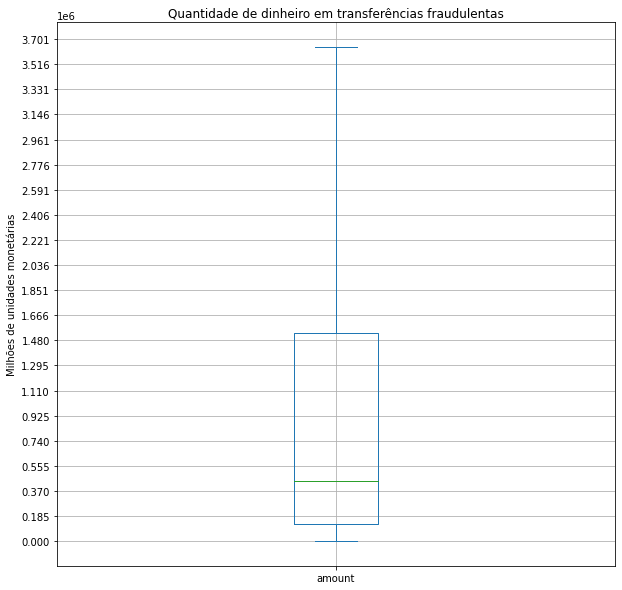

In [ ]:
# Analisando a quantidade de dinheiro em transferências fraudulentas
import numpy as np
first = transfer_fraud["amount"].quantile(0)
last = transfer_fraud["amount"].quantile(0.88)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
transfer_fraud.plot.box(y="amount", figsize = (10,10), grid = True, yticks = ticks, ylabel="Milhões de unidades monetárias", showfliers = False,
                        title = "Quantidade de dinheiro em transferências fraudulentas")
import numpy as np
transfer_fraud["amount"].describe()

Comparando com a distribuição do dinheiro em saques fraudulentos, é razoável concluir que os saques são realizados com todo o dinheiro de uma transferência fraudulenta de autoria do mesmo agente.

count    4.097000e+03
mean     1.846374e+06
std      4.404157e+06
min      0.000000e+00
25%      1.275643e+05
50%      4.448990e+05
75%      1.534985e+06
max      5.958504e+07
Name: oldbalanceOrig, dtype: float64

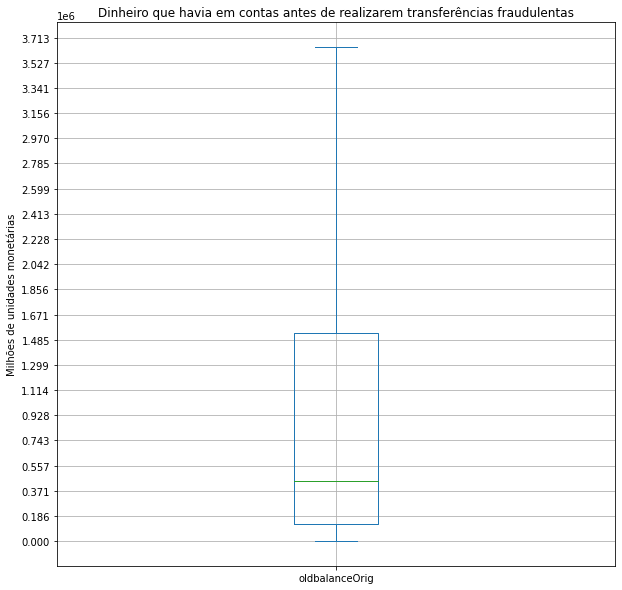

In [ ]:
# Analisando a quantidade de dinheiro que havia em contas antes de realizarem transferências fraudulentas
import numpy as np
first = transfer_fraud["oldbalanceOrig"].quantile(0)
last = transfer_fraud["oldbalanceOrig"].quantile(0.88)
N = 20
ticks = np.arange(first, last+1, step=(last-first)/N)
transfer_fraud.plot.box(y="oldbalanceOrig", figsize = (10,10), grid = True, yticks = ticks, ylabel="Milhões de unidades monetárias", showfliers = False,
                        title = "Dinheiro que havia em contas antes de realizarem transferências fraudulentas")
transfer_fraud["oldbalanceOrig"].describe()

A maioria das contas que iniciam uma transação fraudulenta possuem mais que 440000 em conta, o que reforça a análise de que essas transferências são realizadas por contas de pessoas ricas e/ou empresas.

In [ ]:
transfer_fraud["oldbalanceDest"].describe()

count    4.097000e+03
mean     1.073383e+03
std      3.996103e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.122337e+06
Name: oldbalanceDest, dtype: float64

In [ ]:
transfer_fraud.sort_values(by = "oldbalanceDest", ascending=True).tail(10)

,step,type,amount,oldbalanceOrig,oldbalanceDest,isFraud
3193195,244,TRANSFER,2424380.16,2424380.16,0.00,True
3193203,245,TRANSFER,124311.57,124311.57,0.00,True
3193197,244,TRANSFER,53338.82,53338.82,0.00,True
3193199,244,TRANSFER,1946.74,1946.74,0.00,True
3193201,244,TRANSFER,2468740.94,2468740.94,0.00,True
60853,9,TRANSFER,994453.20,1437370.87,194812.76,True
920521,43,TRANSFER,1395850.55,0.00,260806.21,True
217978,13,TRANSFER,123194.95,79466.45,535933.16,True
138559,11,TRANSFER,1933920.80,0.00,1283762.85,True
1021951,47,TRANSFER,202978.65,0.00,2122336.55,True


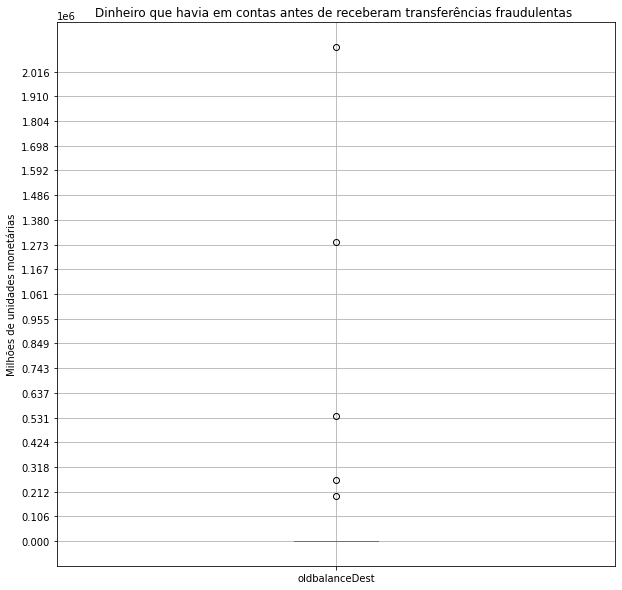

In [ ]:
# Analisando a quantidade de dinheiro que havia em contas antes de receberam transferências fraudulentas
import numpy as np
first = transfer_fraud["oldbalanceDest"].quantile(0)
last = transfer_fraud["oldbalanceDest"].quantile(1)
N = 20
ticks = np.arange(first, last, step=(last-first)/N)
transfer_fraud.plot.box(y="oldbalanceDest", figsize = (10,10), grid = True, yticks = ticks, ylabel="Milhões de unidades monetárias", showfliers = True,
                        title="Dinheiro que havia em contas antes de receberam transferências fraudulentas ")

Com exceção de 5 contas, todas as contas que receberam transferências fraudulentas não possuíam nenhum dinheiro armazenado. Podemos imaginar que isso ocorre devido a terem sido criadas somente para a transferência e, logo após, saque.

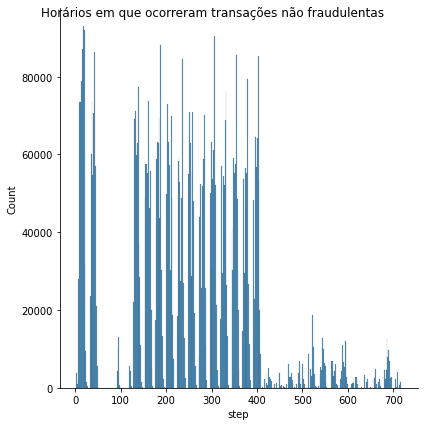

In [ ]:
# Relacionando horário e se a transação é fraudulenta
import seaborn as sns

time_transac_not_fraud = sns.FacetGrid(not_frauds,  height = 6)
time_transac_not_fraud.fig.suptitle("Horários em que ocorreram transações não fraudulentas")
time_transac_not_fraud.map(sns.histplot, "step");

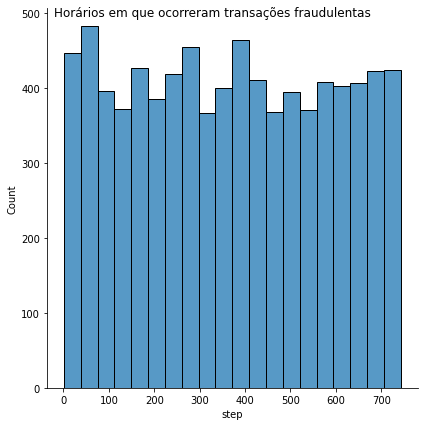

In [ ]:
# Relacionando horário e se a transação é fraudulenta
import seaborn as sns

time_transac_fraud = sns.FacetGrid(frauds,  height = 6)
time_transac_fraud.fig.suptitle("Horários em que ocorreram transações fraudulentas")
time_transac_fraud.map(sns.histplot, "step");

Para o caso de transações fraudulentas, não há muita mudança com o tempo. Entretanto, transações não fraudulenta possuem um ciclo de aumentar e abaixar periodicamente que pode ser relacionado à hora do dia. Podemos interpretar que durante a madrugada as transações não ocorrem com tanta frequência quanto no dia. É importante também notar que após pouco mais da metade do mês as transações abaixam bastante. Uma possível explicação para esse fenômeno é o esgotamento do recurso financeiro de pessoas comuns ao longo do mês, que só será restaurado ao receber salário no começo do mês.

## Análise de relação entre as variáveis

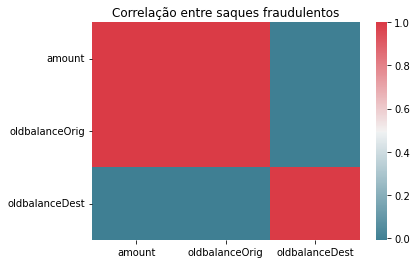

In [ ]:
# Fazendo o heatmap entre variáveis numéricas nos saques fraudulentos
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
corr_frauds_cash_out = cash_out_fraud.loc[:, cash_out_fraud.dtypes=='float64'].corr()
heatmap_frauds = sns.heatmap(corr_frauds_cash_out, xticklabels=corr_frauds_cash_out.columns, yticklabels=corr_frauds_cash_out.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)
ax.set_title("Correlação entre saques fraudulentos")
plt.show()

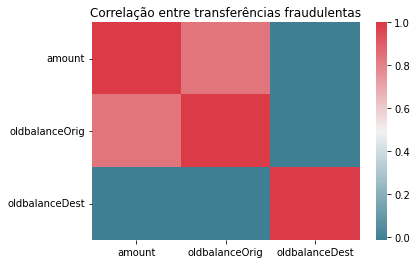

In [ ]:
# Fazendo o heatmap entre variáveis numéricas nas transferências fraudulentas
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
corr_frauds_cash_out = transfer_fraud.loc[:, transfer_fraud.dtypes=='float64'].corr()
heatmap_frauds = sns.heatmap(corr_frauds_cash_out, xticklabels=corr_frauds_cash_out.columns, yticklabels=corr_frauds_cash_out.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)
ax.set_title("Correlação entre transferências fraudulentas")
plt.show()

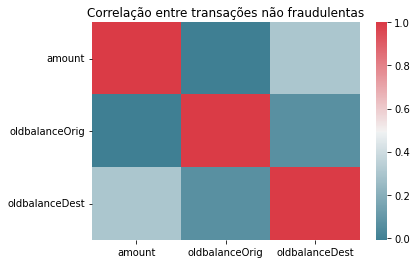

In [ ]:
# Fazendo o heatmap entre variáveis numéricas nas transações não fraudulentas
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
corr_not_frauds = not_frauds.loc[:, not_frauds.dtypes=='float64'].corr()
heatmap_not_frauds = sns.heatmap(corr_not_frauds, xticklabels=corr_not_frauds.columns, yticklabels=corr_not_frauds.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)
ax.set_title("Correlação entre transações não fraudulentas")
plt.show()

Podemos ver que a única relação realmente notável é entre a quantidade de dinheiro na conta de origem de uma transação fraudulenta e o quanto foi passado na transação. No caso dos saques, a relação é quase completamente proporcional, pois todo o dinheiro da conta é sacado. Para transferências, quanto maior a quantidade de dinheiro na conta invadida, mais será desviado.

[Text(0, 0.5, 'Dezenas de milhões movidos na transferência fraudulenta'),
 Text(0.5, 0, 'Dezenas de milhões na conta antes da transferência fraudulenta')]

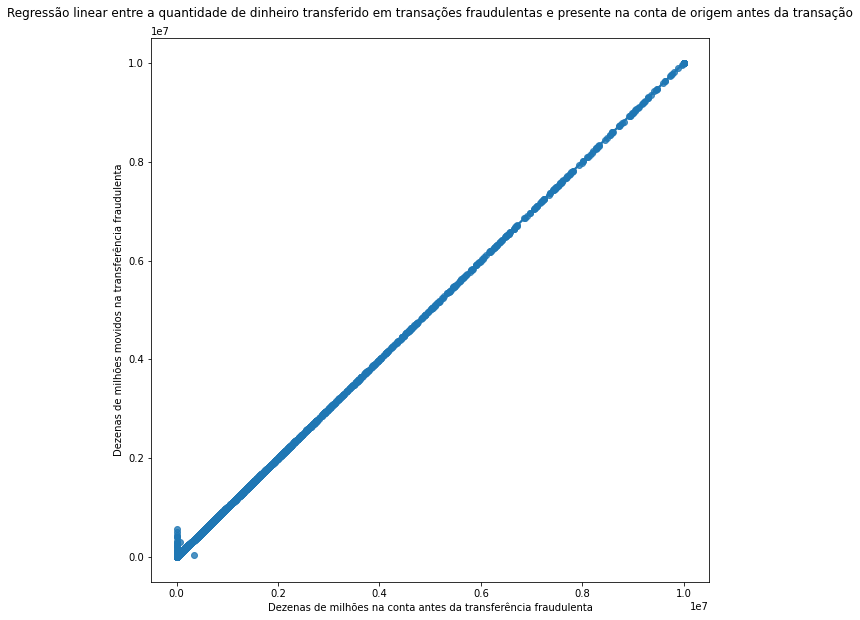

In [ ]:
# Realizando regressão entre amout e oldbalanceOrig em saques fraudulentos
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x=cash_out_fraud["oldbalanceOrig"], y=cash_out_fraud["amount"],
            ax = ax).set_title("Regressão linear entre a quantidade de dinheiro transferido em transações fraudulentas e presente na conta de origem antes da transação\n")
ax.set(xlabel='Dezenas de milhões na conta antes da transferência fraudulenta', ylabel='Dezenas de milhões movidos na transferência fraudulenta')

Está claro que, com a exceção de alguns poucos casos envolvendo menos dinheiro, o saque fraudulento esvazia completamente a conta.

[Text(0, 0.5, 'Dezenas de milhões movidos na transferência fraudulenta'),
 Text(0.5, 0, 'Dezenas de milhões na conta antes da transferência fraudulenta')]

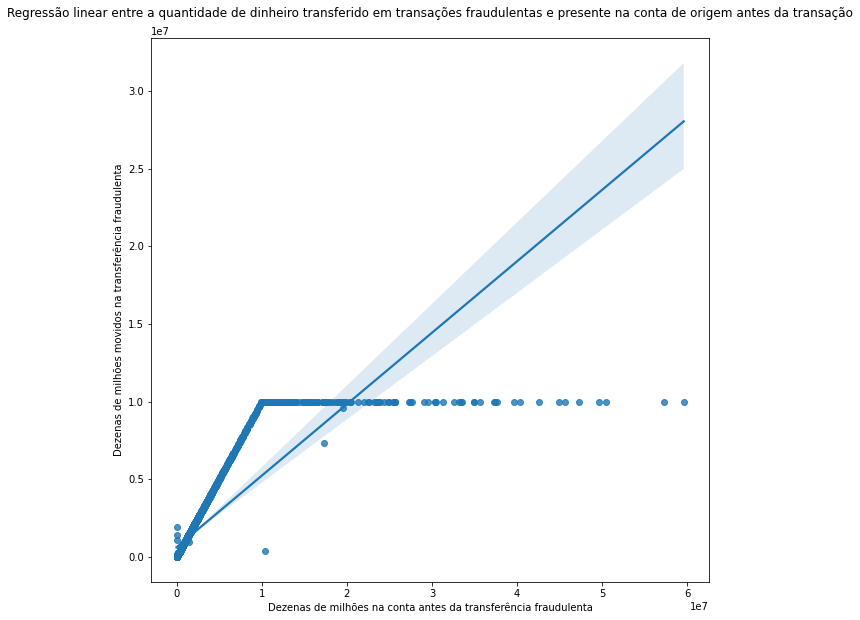

In [ ]:
# Realizando regressão entre amout e oldbalanceOrig em transferências fraudulentas
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x=transfer_fraud["oldbalanceOrig"], y=transfer_fraud["amount"],
            ax = ax).set_title("Regressão linear entre a quantidade de dinheiro transferido em transações fraudulentas e presente na conta de origem antes da transação\n")
ax.set(xlabel='Dezenas de milhões na conta antes da transferência fraudulenta', ylabel='Dezenas de milhões movidos na transferência fraudulenta')

Percebemos que, conforme a conta invadida possuía mais dinheiro, a transferência fraudulenta tendia a mover quase todo ele, com alguns poucos casos fora da curva. Entretanto, há um limite constante para a transferência, que para em 10 milhões. Ainda assim, isso não desvia a transação da suspeita marcada por "isFlaggedFraud", que sinaliza transferências de mais de 200 mil.

In [9]:
df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00
